In [243]:
import torch
import torch.nn as nn 
from torch.optim.optimizer import Optimizer, required
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

class КуикПроп(Optimizer):
    def __init__(self, params, lr=1e-3, weight_decay=0, eps=1e-7):
      
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
            
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
            
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, weight_decay=weight_decay, eps=eps)
       
        super(КуикПроп, self).__init__(params, defaults)

#     def __setstate__(self, state):
#         super(КуикПроп, self).__setstate__(state)
#         for group in self.param_groups:
#             group.setdefault('nesterov', False)
            
    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                state = self.state[p]
                
                if len(state) == 0:
                    state['step'] = 0
                    state['gradprev'] = torch.empty_like(p.data).uniform_(0, 1)
                    state['deltap']   = torch.ones_like(p.data)
               
                state['step'] += 1
                deltaw1 = state['deltap'] * (grad / (state['gradprev'] - grad + group['eps']) )
                state['gradprev'] = grad.clone()
                p.data += group['lr'] * deltaw1
                state['deltap'] = deltaw1.clone() 

                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=weight_decay)
                
                    
#                 if len(state) == 0 :
#                     state['step'] = 0
#                     state['deltap'] = p.data.clone()
#                     state['gradprev'] = grad.clone()
#                     p.data -= group['lr']*grad
#                     state['deltap'] = p.data - state['deltap']
#                     state['step'] += 1
#                     continue
                  
#                 if state['step'] < 3 :
#                     p.data -= group['lr']*grad
#                     state['deltap'] = state['deltap'] * (grad / (state['gradprev'] - grad + group['eps']) )
#                     state['gradprev'] = grad.clone()
#                     state['step'] += 1
#                     continue
                
                
#                 state['step'] += 1
#                 state['deltap'] *= grad / (state['gradprev'] - grad + group['eps']) 
#                 state['gradprev'] = grad.clone()
#                 p.data += group['lr'] * state['deltap']
                
                
        return loss

In [244]:
device = torch.device('cpu')
torch.manual_seed(0)
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold input and outputs
x = torch.randn(N, D_in, device=device)
y = torch.randn(N, D_out, device=device)

model = nn.Sequential(
        nn.Linear(D_in, H),
        nn.ReLU(),
        nn.Linear(H, D_out)
        ).to(device)





lr=1e-6
criterion = nn.MSELoss()
optimizer1 = КуикПроп(model.parameters(),lr=lr)
optimizer2 = torch.optim.Adam(model.parameters(), lr=lr)
optimizer3 = torch.optim.SGD(model.parameters(), lr=lr)

optims = {'Quickprop': optimizer1, 'Adam': optimizer2, 'SGD': optimizer3}

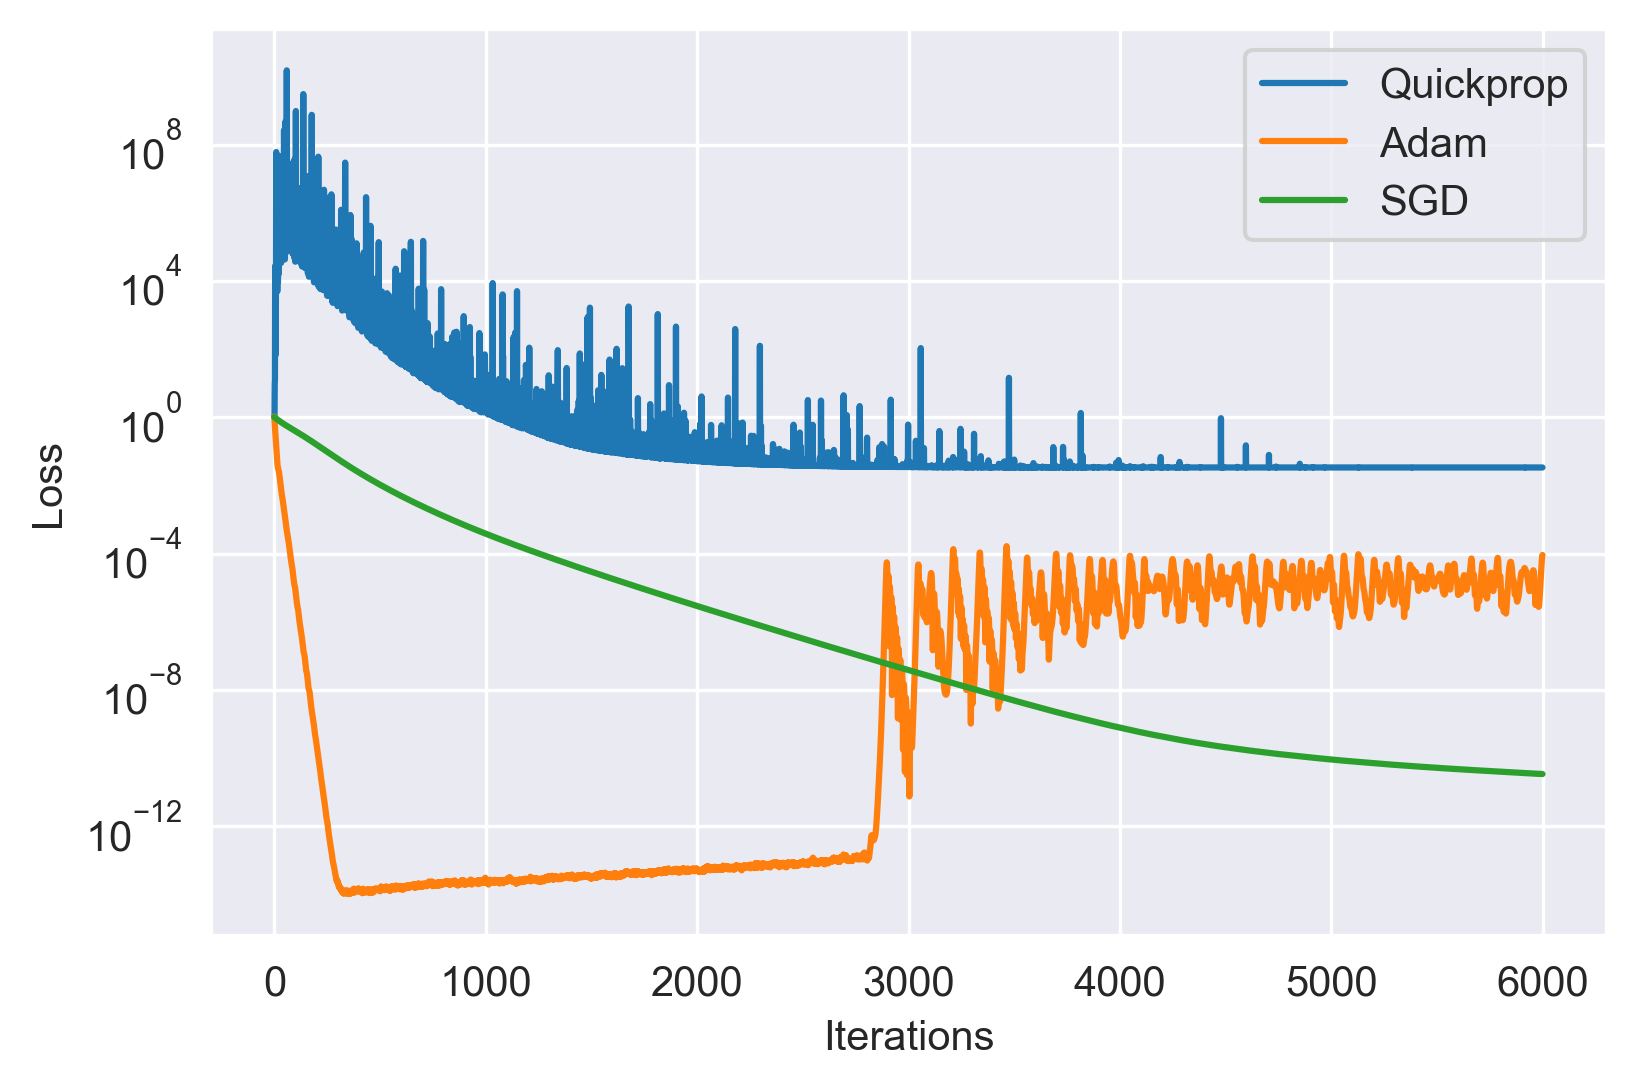

In [245]:
plt.figure(dpi=300)
for op in optims:
    losses = []
    
    
    model = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
            ).to(device)
    
#     model = nn.Sequential(
#         nn.Linear(D_in, H),
#         nn.ReLU(),
#         nn.Linear(H, H*2),
#         nn.ReLU(),
#         nn.Linear(H*2, D_out)
#         ).to(device)
    
    optimizer1 = КуикПроп(model.parameters(), lr=1e-6)
    optimizer2 = torch.optim.Adam(model.parameters(), lr=1e-3)
    optimizer3 = torch.optim.SGD(model.parameters(), lr=1e-2)
    optims = {'Quickprop': optimizer1, 'Adam': optimizer2, 'SGD': optimizer3}
    
    for i in range(6000):
        output = model(x)
        loss   = criterion(output,y) 
        optims[op].zero_grad()
        loss.backward()
        optims[op].step()
        losses.append(loss.item())

        
    plt.semilogy(losses, label=op)
    plt.ylabel('Loss')
    plt.xlabel('Iterations')
#     plt.title()
    plt.legend()
plt.show()